In [1]:
import pandas as pd 
import numpy as np 
import random
import matplotlib.pyplot as plt 
import json
import folium
import networkx as nx

# 1. load data
The data file introduction is below:
1. **u.data**:   The full u data set, `100000 ratings` by `943 users` on `1682 items`. Each user has rated at least 20 movies.  Users and items are numbered consecutively from 1.  The data is randomly ordered. The time stamps are unix seconds since 1/1/1970 UTC.   

2. **u.item**: Information about the items (movies); The last `19 fields` are the genres, a 1 indicates the movie is of that genre, a 0 indicates it is not; movies can be in several genres at once. 

3. **u.genre**: A list of the genres.

4. **u.user**: Demographic information about the users

5. **u.occupation**: A list of the occupations.

# 2. Data analysis

## 2.1 Movie data

In [2]:
############################### Genre of the movies ############################### 
genre_data= pd.read_csv('ml-100k/u.genre',sep='|',names=["movie_type", "type_id"])
genre_data.head()

movie_type  type_id
0     unknown        0
1      Action        1
2   Adventure        2
3   Animation        3
4  Children's        4

In [3]:
genre_cls = ["unknown", "Action", "Adventure", "Animation", \
              "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", \
              "Sci-Fi", "Thriller", "War", "Western"]

In [4]:
############################### Information about the items (movies) ###############################
column_names = ["movie_id", "movie_title", "release_date", "video_release_date", "IMDb_URL", "unknown", "Action", "Adventure", "Animation", \
              "Childrens", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", \
              "Sci-Fi", "Thriller", "War", "Western"]
movies_data = pd.read_csv('ml-100k/u.item',sep='|', names=column_names,encoding = "ISO-8859-1")
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'])
movies_data.rename(columns = {'movie_id':'item_id'}, inplace = True) 
movies_data

item_id                                movie_title release_date  \
0           1                           Toy Story (1995)   1995-01-01   
1           2                           GoldenEye (1995)   1995-01-01   
2           3                          Four Rooms (1995)   1995-01-01   
3           4                          Get Shorty (1995)   1995-01-01   
4           5                             Copycat (1995)   1995-01-01   
...       ...                                        ...          ...   
1677     1678                          Mat' i syn (1997)   1998-02-06   
1678     1679                           B. Monkey (1998)   1998-02-06   
1679     1680                       Sliding Doors (1998)   1998-01-01   
1680     1681                        You So Crazy (1994)   1994-01-01   
1681     1682  Scream of Stone (Schrei aus Stein) (1991)   1996-03-08   

      video_release_date                                           IMDb_URL  \
0                    NaN  http://us.imdb.com/M/title-exact?Toy%20Story%2...   
1                    NaN  http://us.imdb.com/M/title-exact?GoldenEye%20(...   
2                    NaN  http://us.imdb.com/M/title-exact?Four%20Rooms%...   
3                    NaN  http://us.imdb.com/M/title-exact?Get%20Shorty%...   
4                    NaN  http://us.imdb.com/M/title-exact?Copycat%20(1995)   
...                  ...                                                ...   
1677                 NaN  http://us.imdb.com/M/title-exact?Mat%27+i+syn+...   
1678                 NaN  http://us.imdb.com/M/title-exact?B%2E+Monkey+(...   
1679                 NaN      http://us.imdb.com/Title?Sliding+Doors+(1998)   
1680                 NaN  http://us.imdb.com/M/title-exact?You%20So%20Cr...   
1681                 NaN  http://us.imdb.com/M/title-exact?Schrei%20aus%...   

      unknown  Action  Adventure  Animation  Childrens  ...  Fantasy  \
0           0       0          0          1          1  ...        0   
1           0       1          1          0          0  ...        0   
2           0       0          0          0          0  ...        0   
3           0       1          0          0          0  ...        0   
4           0       0          0          0          0  ...        0   
...       ...     ...        ...        ...        ...  ...      ...   
1677        0       0          0          0          0  ...        0   
1678        0       0          0          0          0  ...        0   
1679        0       0          0          0          0  ...        0   
1680        0       0          0          0          0  ...        0   
1681        0       0          0          0          0  ...        0   

      Film-Noir  Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0             0       0        0        0        0       0         0    0   
1             0       0        0        0        0       0         1    0   
2             0       0        0        0        0       0         1    0   
3             0       0        0        0        0       0         0    0   
4             0       0        0        0        0       0         1    0   
...         ...     ...      ...      ...      ...     ...       ...  ...   
1677          0       0        0        0        0       0         0    0   
1678          0       0        0        0        1       0         1    0   
1679          0       0        0        0        1       0         0    0   
1680          0       0        0        0        0       0         0    0   
1681          0       0        0        0        0       0         0    0   

      Western  
0           0  
1           0  
2           0  
3           0  
4           0  
...       ...  
1677        0  
1678        0  
1679        0  
1680        0  
1681        0  

[1682 rows x 24 columns]

### Duplicated records
We found that there are movies that share exactly the same information but with different item_id (primary key). And there are exactly 18 movies that has such a duplication so in total 36 records that are not unique. We deal with these duplications later on, after checking if the original and the duplicate are both rated by users.

In [24]:
duplicated = movies_data[movies_data.duplicated('movie_title', False)].sort_values(by = 'movie_title')
duplicated.head()

item_id                   movie_title release_date  video_release_date  \
669       670         Body Snatchers (1993)   1993-01-01                 NaN   
572       573         Body Snatchers (1993)   1993-01-01                 NaN   
1649     1650       Butcher Boy, The (1998)   1998-01-01                 NaN   
1644     1645       Butcher Boy, The (1998)   1998-01-01                 NaN   
1233     1234  Chairman of the Board (1998)   1998-01-01                 NaN   

                                               IMDb_URL  unknown  Action  \
669   http://us.imdb.com/M/title-exact?Body%20Snatch...        0       0   
572   http://us.imdb.com/M/title-exact?Body%20Snatch...        0       0   
1649  http://us.imdb.com/M/title-exact?imdb-title-11...        0       0   
1644  http://us.imdb.com/M/title-exact?imdb-title-11...        0       0   
1233  http://us.imdb.com/Title?Chairman+of+the+Board...        0       0   

      Adventure  Animation  Childrens  ...  Film-Noir  Horror  Musical  \
669           0          0          0  ...          0       1        0   
572           0          0          0  ...          0       1        0   
1649          0          0          0  ...          0       0        0   
1644          0          0          0  ...          0       0        0   
1233          0          0          0  ...          0       0        0   

      Mystery  Romance  Sci-Fi  Thriller  War  Western  year_label  
669         0        0       1         1    0        0        1993  
572         0        0       1         1    0        0        1993  
1649        0        0       0         0    0        0        1998  
1644        0        0       0         0    0        0        1998  
1233        0        0       0         0    0        0        1998  

[5 rows x 25 columns]

### NaN record
We find that there is a record contains NaN for most of its attributes. However, we later on also found that there are users who did rate this item. So we decide not to drop this record.

In [6]:
movies_data[movies_data.release_date.isnull()]

item_id movie_title release_date  video_release_date IMDb_URL  unknown  \
266      267     unknown          NaT                 NaN      NaN        1   

     Action  Adventure  Animation  Childrens  ...  Fantasy  Film-Noir  Horror  \
266       0          0          0          0  ...        0          0       0   

     Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
266        0        0        0       0         0    0        0  

[1 rows x 24 columns]

In [7]:
movies_data[movies_data.index == 266]

item_id movie_title release_date  video_release_date IMDb_URL  unknown  \
266      267     unknown          NaT                 NaN      NaN        1   

     Action  Adventure  Animation  Childrens  ...  Fantasy  Film-Noir  Horror  \
266       0          0          0          0  ...        0          0       0   

     Musical  Mystery  Romance  Sci-Fi  Thriller  War  Western  
266        0        0        0       0         0    0        0  

[1 rows x 24 columns]

### Year Cleaning
The movies lie in a span of 77 years.

In [8]:
l = sorted(movies_data.release_date.dt.year.unique().tolist())
max(l)  - min(l) + 1

77.0

#### Histogram of movies w.r.t. release year

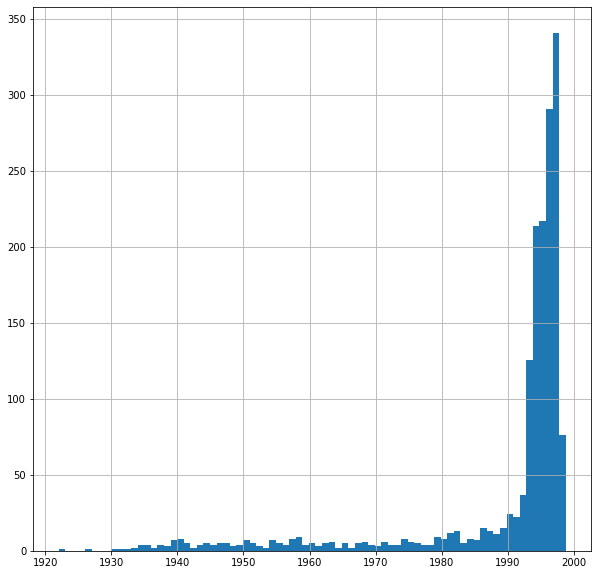

In [13]:
movies_data.release_date.hist(bins = 77, figsize = (10, 10))

Observing from the histogram showing the number of movies for each each, we notice that the movies mainly are released during 1990 and 1998. In order to facilitate the computation of similarity, we wish to aggregate years in which too few moives are released.

In [10]:
def compute_year_label(row):
    year = row['release_date'].year
    
    if year <= 1990 or np.isnan(year):
        return 1990
    else:
        return year

In [11]:
movies_data['year_label'] = movies_data.apply(lambda row: compute_year_label(row), axis = 1)

In [12]:
movies_data.year_label.unique()

array([1995, 1996, 1994, 1990, 1993, 1992, 1991, 1997, 1998])

### 2.1.1 statistical infos

#### Histogram of movies under each year label.

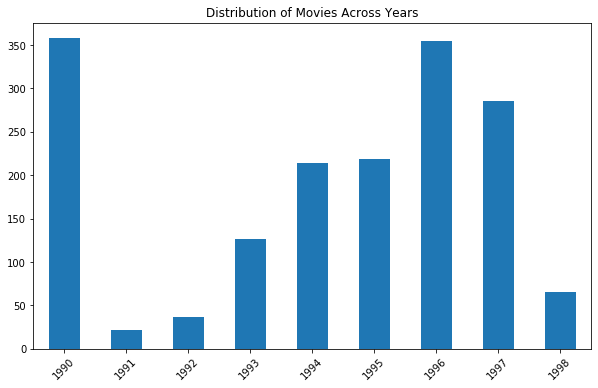

In [22]:
movies_data.year_label.value_counts().sort_index()\
.plot(kind = 'bar', rot = 45, figsize = (10, 6), title = 'Distribution of Movies Across Years')

#### The number of movies that falls in each genre.

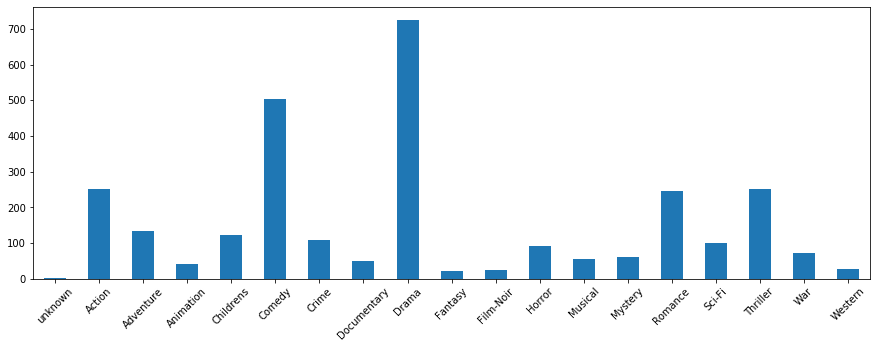

In [23]:
movies_data.sum()[movies_data.columns[5:-1]].plot(kind = 'bar', figsize = (15, 5), rot = 45)

Below we take a glimpse of the percentage of each genere's movies in each year.

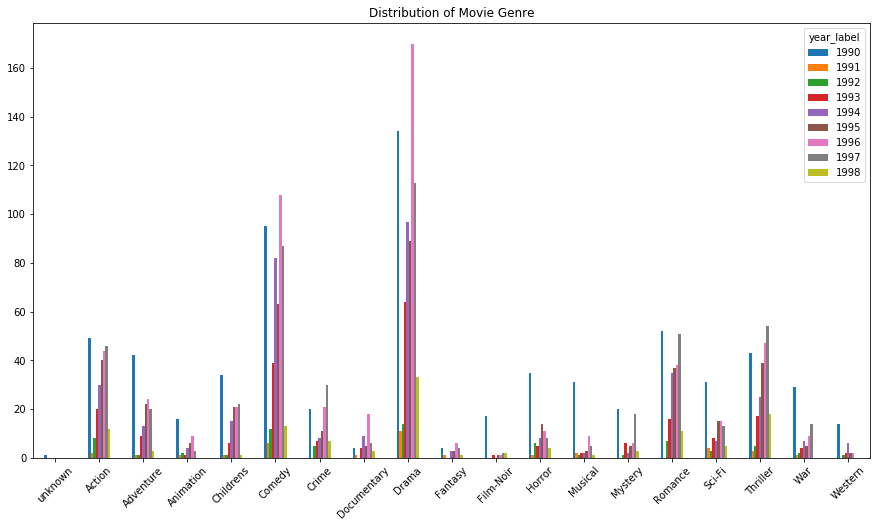

In [15]:
movies_data[movies_data.movie_title != 'unknown'].groupby('year_label').sum()[genre_cls].T\
        .plot(kind = 'bar', rot=45, figsize=(15,8), title = 'Distribution of Movie Genre')

Below we take a look at year 1995 - 1998 as an exmaple.

In [67]:
movie_1995 = movies_data[movies_data['release_date'].dt.year == 1995]
movie_1996 = movies_data[movies_data['release_date'].dt.year == 1996]
movie_1997 = movies_data[movies_data['release_date'].dt.year == 1997]
movie_1998 = movies_data[movies_data['release_date'].dt.year == 1998]

Text(0.5, 1.0, 'genres percentage over year')

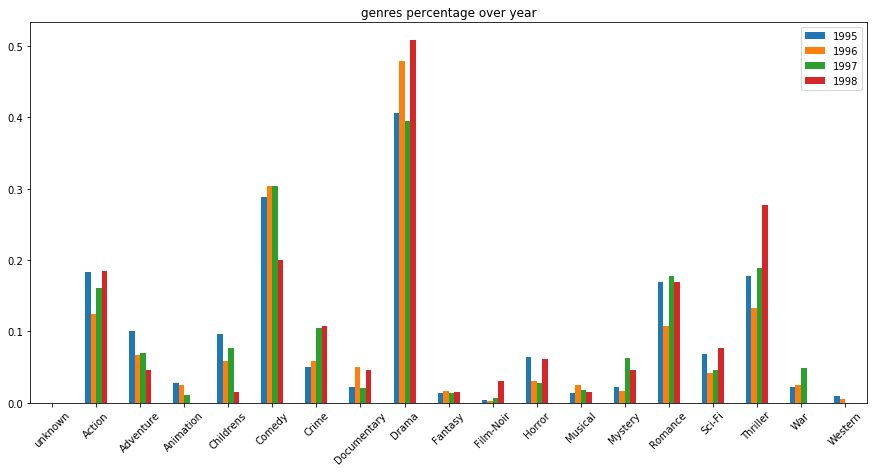

In [69]:
Year = {}
Year[1995] = movie_1995[genre_cls].sum()/len(movie_1995)
Year[1996] = movie_1996[genre_cls].sum()/len(movie_1996)
Year[1997] = movie_1997[genre_cls].sum()/len(movie_1997)
Year[1998] = movie_1998[genre_cls].sum()/len(movie_1998)
movie_year = pd.DataFrame(Year) 
axes = movie_year.plot.bar(rot=45,figsize=(15,7))
axes.set_title('genres percentage over year')

We conclude that the distribution of movie genres are generally balanced and hence are not biased.

## 2.2 user data

In [16]:
############################### Demographic information about the users ###############################
column_names = ["user_id", "age", "gender", "occupation", "zip_code"]
user_data = pd.read_csv('ml-100k/u.user',sep='|', names=column_names)
user_data

user_id  age gender     occupation zip_code
0          1   24      M     technician    85711
1          2   53      F          other    94043
2          3   23      M         writer    32067
3          4   24      M     technician    43537
4          5   33      F          other    15213
..       ...  ...    ...            ...      ...
938      939   26      F        student    33319
939      940   32      M  administrator    02215
940      941   20      M        student    97229
941      942   48      F      librarian    78209
942      943   22      M        student    77841

[943 rows x 5 columns]

In [17]:
############################### A list of the occupations(the jobs types of users). ############################### 
occupation_data = pd.read_csv('ml-100k/u.occupation',sep='|',names=["occupation"])
occupation_data = occupation_data.reset_index().rename(columns={'index':'occupation_id'})

occupation_data.head()

occupation_id     occupation
0              0  administrator
1              1         artist
2              2         doctor
3              3       educator
4              4       engineer

### 2.2.1 statistical info

#### Gender

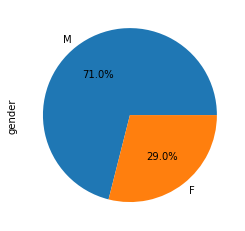

In [73]:
user_data['gender'].value_counts().plot(kind='pie', autopct='%1.1f%%')

#### Age

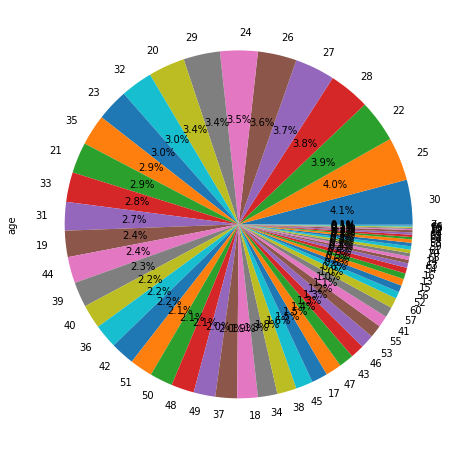

In [74]:
user_data['age'].value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(8,8))

#### Occupation

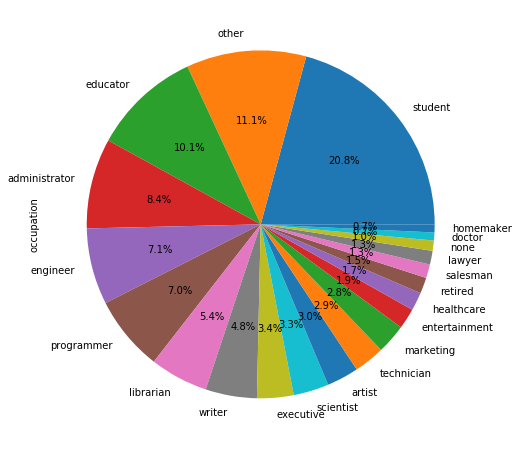

In [75]:
user_data['occupation'].value_counts().plot(kind='pie', autopct='%1.1f%%',figsize=(8,8))

### 2.2.2 location

We wish to find the geographical distribution of the users and to show them on a map. The only information we are given about this is the zip code and we find out there are only two countries involving these zip codes: America and Canada. And below we find out the number of users in Canada.

In [245]:
canada = 0
for i in range(len(user_data)):
    if user_data.loc[i].zip_code.isdigit() == False:
        canada += 1

canada

18

Geopy is used to find the exact coordinate corresponding to a zip code. And this information is stored in a dictionary.

In [246]:
code_table = {x: (0, 0) for x in user_data.zip_code.unique().tolist()}

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="liu")

for zip_code in code_table:
    if code_table[zip_code] != (0, 0):
        continue
    
    query_code = zip_code
    
    if query_code.isdigit() == False:
        continue

    location = location = geolocator.geocode(query_code, country_codes = ['US'], timeout = 10)
    if not location:
        continue
    code_table[zip_code] = (location.latitude, location.longitude)

In [233]:
user_data['coordinate'] = user_data.apply(lambda row: code_table[row['zip_code']], axis = 1)

In [248]:
user_data.head()

user_id  age gender  occupation zip_code  \
0        1   24      M  technician    85711   
1        2   53      F       other    94043   
2        3   23      M      writer    32067   
3        4   24      M  technician    43537   
4        5   33      F       other    15213   

                              coordinate  
0  (32.2237655028609, -110.870918674932)  
1   (37.406948363578, -122.089973532962)  
2              (30.6936414, -88.1788365)  
3                (41.561959, -83.646264)  
4              (40.4282335, -79.9544998)

In [247]:
map2 = folium.Map(location=[38.9, -77.05], zoom_start=11)

from folium.plugins import MarkerCluster
marker_cluster = MarkerCluster().add_to(map2)


for i in range(0, len(user_data)):
    if user_data.loc[i].coordinate == (0, 0) or user_data.loc[i].zip_code.isdigit() == False:
        continue
    folium.Marker(user_data.loc[i].coordinate, popup=user_data.loc[i].user_id, icon=folium.Icon(color='darkblue', icon_color='white', icon='male', angle=0, prefix='fa')).add_to(marker_cluster)

<img src='image/MAP.PNG'>

## 2.3 Relational Info between Users and Movies

In [38]:
############################### Create user_item_matrix ############################### 
data= pd.read_csv('ml-100k/u.data',sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
data.head()

user_id  item_id  rating           timestamp
0      196      242       3 1997-12-04 15:55:49
1      186      302       3 1998-04-04 19:22:22
2       22      377       1 1997-11-07 07:18:36
3      244       51       2 1997-11-27 05:02:03
4      166      346       1 1998-02-02 05:33:16

Here we check for the duplicated items to see whether both of the two duplicated items are rated by users in this relational table.

In [30]:
data.merge(duplicated.item_id, on = 'item_id').item_id.nunique()

36

Because all the 36 items are reviewed by some users, so we conclude that the duplicated items have been both rated by users. Therefore, to remove the duplicates, we need to select one of the duplicated items as the main movie and direct all the ratings towards the other movie to this main one.

In [31]:
data.merge(duplicated.item_id, on = 'item_id')

user_id  item_id  rating           timestamp
0          50      246       3 1997-10-17 01:38:49
1         269      246       5 1998-04-01 18:57:47
2          99      246       3 1998-02-26 05:03:12
3         276      246       4 1997-09-20 20:18:06
4          79      246       5 1998-03-30 15:25:45
...       ...      ...     ...                 ...
1264      116     1256       1 1997-10-10 03:13:42
1265      463     1606       2 1998-03-15 04:36:05
1266      863     1680       2 1998-03-07 16:52:50
1267      587     1625       4 1998-04-18 03:55:32
1268      655     1645       4 1998-04-18 03:47:05

[1269 rows x 4 columns]

Below we find the item id to be replaced and the item id that is going to be used.

In [71]:
duplicated_items = duplicated[['item_id', 'movie_title']].groupby('movie_title').apply(lambda x: list(x.item_id))
# remove_pattern = pd.DataFrame(duplicated_items.tolist(), index = duplicated_items.index, columns = ['item_id1', 'item_id2'])
to_replace = {}
for i, j in duplicated_items.values.tolist():
    to_replace[i] = j
to_replace

{670: 573,
 1650: 1645,
 1234: 1654,
 246: 268,
 1606: 309,
 1257: 1256,
 348: 329,
 500: 304,
 1617: 1175,
 1607: 1395,
 305: 865,
 680: 266,
 876: 881,
 1625: 1477,
 1680: 1429,
 1658: 711,
 1003: 878,
 303: 297}

Replace the duplicated item id with the replacement pattern shown above

In [73]:
data.replace({'item_id': to_replace}, inplace = True)

In [75]:
data.item_id.nunique()

1664

In [76]:
movies_data.item_id.nunique()

1682

We see that the 18 duplicated items are correctly replaced by its counterpart.

In [79]:
data_merged = pd.merge(data,user_data,on='user_id',how='left')
data_merged = pd.merge(data_merged,movies_data,on='item_id',how='left')
data_merged

user_id  item_id  rating           timestamp  age gender  \
0          196      242       3 1997-12-04 15:55:49   49      M   
1          186      302       3 1998-04-04 19:22:22   39      F   
2           22      377       1 1997-11-07 07:18:36   25      M   
3          244       51       2 1997-11-27 05:02:03   28      M   
4          166      346       1 1998-02-02 05:33:16   47      M   
...        ...      ...     ...                 ...  ...    ...   
99995      880      476       3 1997-11-22 05:10:44   13      M   
99996      716      204       5 1997-11-17 19:39:03   36      F   
99997      276     1090       1 1997-09-20 22:49:55   21      M   
99998       13      225       2 1997-12-17 22:52:36   47      M   
99999       12      203       3 1997-11-19 17:13:03   28      F   

          occupation zip_code                   movie_title release_date  ...  \
0             writer    55105                  Kolya (1996)   1997-01-24  ...   
1          executive    00000      L.A. Confidential (1997)   1997-01-01  ...   
2             writer    40206           Heavyweights (1994)   1994-01-01  ...   
3         technician    80525    Legends of the Fall (1994)   1994-01-01  ...   
4           educator    55113           Jackie Brown (1997)   1997-01-01  ...   
...              ...      ...                           ...          ...  ...   
99995        student    83702  First Wives Club, The (1996)   1996-09-14  ...   
99996  administrator    44265     Back to the Future (1985)   1985-01-01  ...   
99997        student    95064                 Sliver (1993)   1993-01-01  ...   
99998       educator    29206         101 Dalmatians (1996)   1996-11-27  ...   
99999          other    06405             Unforgiven (1992)   1992-01-01  ...   

       Film-Noir Horror  Musical  Mystery  Romance  Sci-Fi  Thriller  War  \
0              0      0        0        0        0       0         0    0   
1              1      0        0        1        0       0         1    0   
2              0      0        0        0        0       0         0    0   
3              0      0        0        0        1       0         0    1   
4              0      0        0        0        0       0         0    0   
...          ...    ...      ...      ...      ...     ...       ...  ...   
99995          0      0        0        0        0       0         0    0   
99996          0      0        0        0        0       1         0    0   
99997          0      0        0        0        0       0         1    0   
99998          0      0        0        0        0       0         0    0   
99999          0      0        0        0        0       0         0    0   

       Western  year_label  
0            0        1997  
1            0        1997  
2            0        1994  
3            1        1994  
4            0        1997  
...        ...         ...  
99995        0        1996  
99996        0        1990  
99997        0        1993  
99998        0        1996  
99999        1        1992  

[100000 rows x 32 columns]

We find that users only rated all these movies in 1997 and 1998.

In [80]:
data_merged.timestamp.dt.year.unique()

array([1997, 1998])

#### top5 most rated movies for each year
Below we find the top 5 movies that are rated the most in each year and in total respectively.

In [370]:
data_1997 = data_merged[data_merged['timestamp'].dt.year == 1997]
data_1998 = data_merged[data_merged['timestamp'].dt.year == 1998]

In [381]:
data_1997.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

count
movie_title                     
Star Wars (1977)             335
Fargo (1996)                 301
Return of the Jedi (1983)    300
Toy Story (1995)             267
Liar Liar (1997)             261

In [382]:
data_1998.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

count
movie_title                
Titanic (1997)          322
Contact (1997)          264
Star Wars (1977)        248
Air Force One (1997)    241
Scream (1996)           238

In [383]:
data_merged.groupby('movie_title').count()[['item_id']].nlargest(5, columns = 'item_id').rename(columns={"item_id": 'count'})

count
movie_title                     
Star Wars (1977)             583
Contact (1997)               509
Fargo (1996)                 508
Return of the Jedi (1983)    507
Liar Liar (1997)             485

Text(0.5, 1.0, 'genres percentage over year')

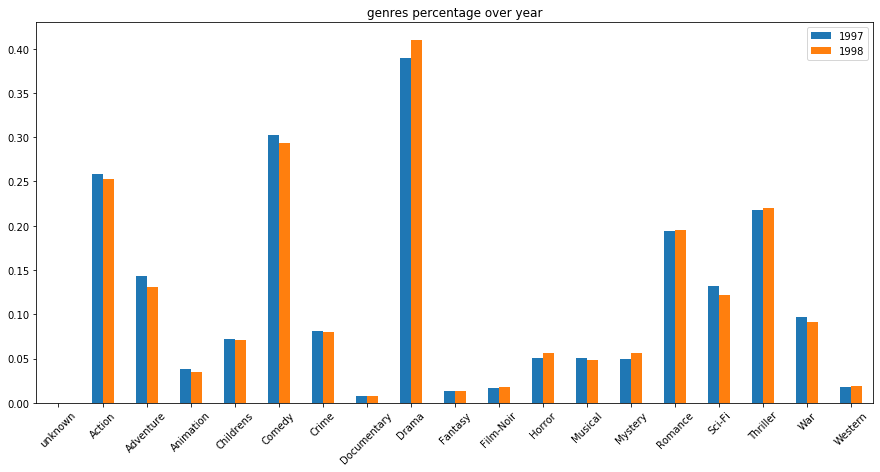

In [384]:
## the most rated movie genre every year
Popular = {}
Popular[1997] = data_1997[genre_cls].sum()/len(data_1997)
Popular[1998] = data_1998[genre_cls].sum()/len(data_1998)
Popular_year = pd.DataFrame(Popular) 
axes = Popular_year.plot.bar(rot=45,figsize=(15,7))
axes.set_title('genres percentage over year')

# 3. Graph analysis

## 3.1 user graph

In [386]:
def plt_graph(adjacency,data,title):
    graph_user = nx.from_numpy_matrix(adjacency)
    print('The number of connected components is {}'.format(nx.number_connected_components(graph_user)))
    coords = nx.spring_layout(graph_user,k=0.03)  # Force-directed layout.
    fig=plt.figure(figsize=(15, 10))
    labels = data.iloc[np.sort(nx.nodes(graph_user))]
    im=nx.draw_networkx_nodes(graph_user, coords, node_size=40,node_color=labels, cmap='tab20b',vmin=min(data), vmax=max(data))
    nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
    plt.title(title)
    plt.colorbar(im)
    return graph_user

In [395]:
# Initialize the adjacency matrix
n_users = len(user_data)
adjacency_user = np.zeros((n_users, n_users), dtype=float)
user_features1 =user_data.copy()[['user_id', 'age', 'gender', 'occupation', 'zip_code']]
user_features1['age_normal'] = user_features1['age']/max(user_features1['age'])
user_features1= pd.merge(user_features1,occupation_data,on='occupation',how='left')
user_features1['gender_id'] = user_features1['gender'].replace(['M','F'],[1,0])

In [396]:
user_features2=user_features1[['user_id','age','gender','occupation_id']].copy()
user_features2['avg_rating'] = data_merged[['user_id','item_id','rating']].groupby('user_id').mean()['rating'].values
user_features2['movie'] = data_merged[['user_id','item_id','rating']].groupby('user_id')['item_id'].apply(set).values

In [397]:
user_features1

user_id  age gender     occupation zip_code  age_normal  occupation_id  \
0          1   24      M     technician    85711    0.328767             19   
1          2   53      F          other    94043    0.726027             13   
2          3   23      M         writer    32067    0.315068             20   
3          4   24      M     technician    43537    0.328767             19   
4          5   33      F          other    15213    0.452055             13   
..       ...  ...    ...            ...      ...         ...            ...   
938      939   26      F        student    33319    0.356164             18   
939      940   32      M  administrator    02215    0.438356              0   
940      941   20      M        student    97229    0.273973             18   
941      942   48      F      librarian    78209    0.657534             10   
942      943   22      M        student    77841    0.301370             18   

     gender_id  
0            1  
1            0  
2            1  
3            1  
4            0  
..         ...  
938          0  
939          1  
940          1  
941          0  
942          1  

[943 rows x 8 columns]

In [398]:
user_features2

user_id  age gender  occupation_id  avg_rating  \
0          1   24      M             19    3.610294   
1          2   53      F             13    3.709677   
2          3   23      M             20    2.796296   
3          4   24      M             19    4.333333   
4          5   33      F             13    2.874286   
..       ...  ...    ...            ...         ...   
938      939   26      F             18    4.265306   
939      940   32      M              0    3.457944   
940      941   20      M             18    4.045455   
941      942   48      F             10    4.265823   
942      943   22      M             18    3.410714   

                                                 movie  
0    {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...  
1    {257, 258, 1, 10, 13, 14, 269, 272, 273, 274, ...  
2    {258, 260, 264, 268, 271, 272, 288, 294, 299, ...  
3    {258, 260, 264, 11, 271, 288, 294, 300, 301, 3...  
4    {1, 2, 17, 21, 24, 25, 29, 40, 42, 50, 62, 63,...  
..                                                 ...  
938  {257, 258, 255, 1028, 9, 266, 15, 274, 275, 40...  
939  {4, 516, 7, 8, 9, 521, 12, 14, 527, 529, 549, ...  
940  {257, 258, 1, 7, 15, 273, 147, 919, 408, 294, ...  
941  {514, 1028, 520, 528, 1050, 539, 31, 50, 71, 5...  
942  {2, 1028, 9, 11, 12, 526, 1044, 22, 23, 24, 10...  

[943 rows x 6 columns]

### Metric 1: measure similarity between users by their age, gender, occupation and residence.

In [640]:
def similarity(row,data):
    sim = pd.DataFrame(np.cos(row['age_normal']-data['age_normal']))
    sim['gender'] = (row['gender']==data['gender'])
    sim['occupation'] = (row['occupation']==data['occupation'])
    sim['zip_code'] = (row['zip_code'] == data['zip_code'])
    return sim

In [641]:
for i in range(n_users):
    adjacency_user[i,:] = similarity(user_features1.loc[i,:],user_features1).mean(axis=1)

#### Adjacency Matrix of users

Text(0.5, 1.05, 'Adjacency matrix')

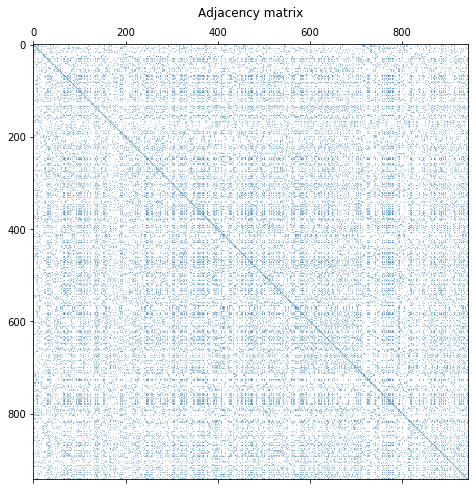

In [642]:
mask = adjacency_user<=0.5
adjacency = adjacency_user.copy()
adjacency[mask]=0

plt.figure(figsize=(8,8))
plt.spy(adjacency,markersize=0.1)
plt.title('Adjacency matrix')

#### User Graph 1 with colors representing gender

No specific pattern is identified from the distribution of the colours of the nodes.

The number of connected components is 12


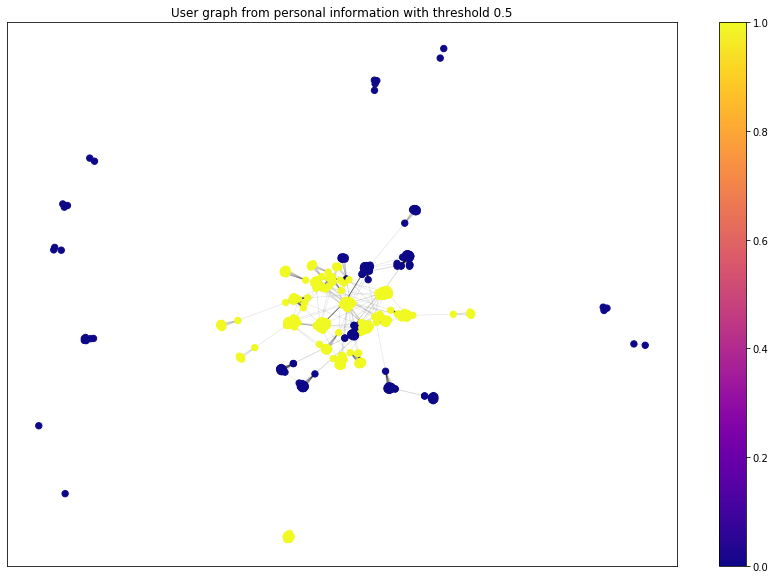

In [426]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['gender_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='plasma',vmin=0, vmax=1)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### User Graph 1 with colors representing Occupation

We do observe that there is nice and clear pattern here, as the nodes of the same colour falls in one cluster, meaning that people of the same occupation do share lots of similarities with repsect to movies of interest.

The number of connected components is 12


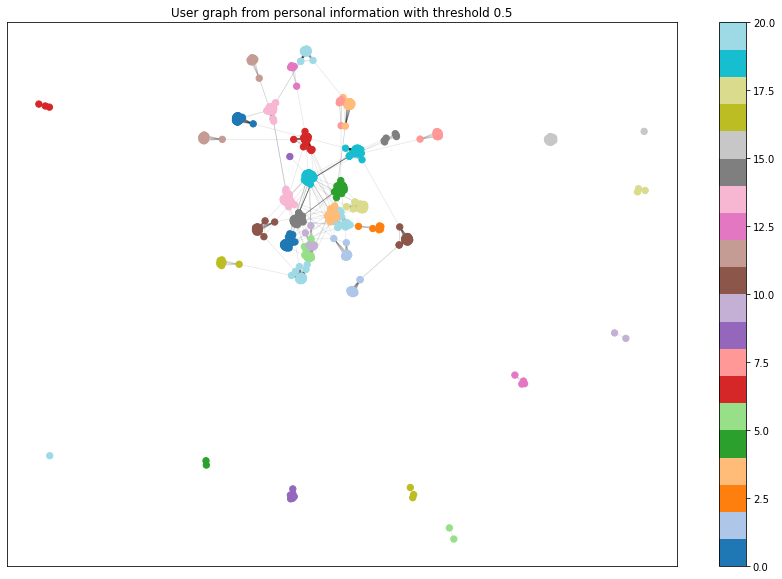

In [427]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### User Graph 1 with colors representing Age
No specific pattern is identified from the distribution of the colours of the nodes.

The number of connected components is 12


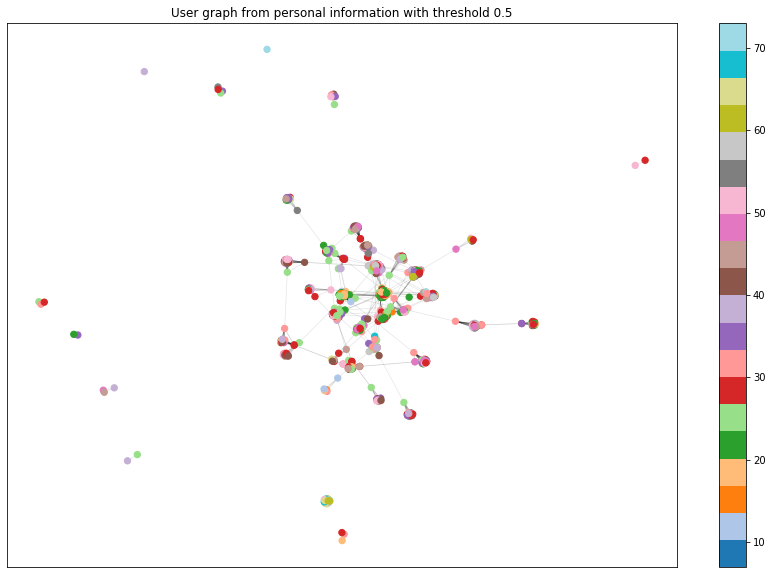

In [428]:
graph_user = nx.from_numpy_matrix(adjacency)
G = graph_user
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['age'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from personal information with threshold 0.5')
plt.colorbar(im)

#### Giant Components in User Graph 1

The number of nodes is is 903


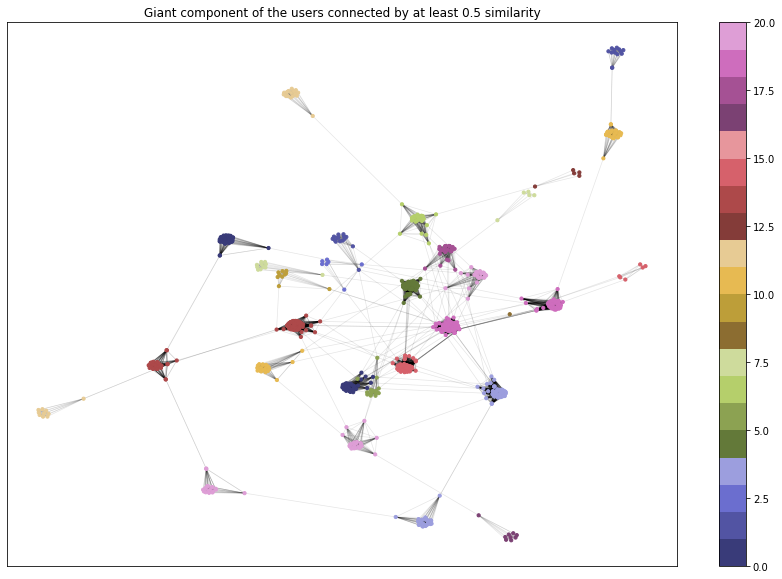

In [504]:
G = graph_user1
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20b',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the users connected by at least 0.5 similarity')
plt.colorbar(im);

#### Below we analyse the graph from the view of spectal theory

In [645]:
def compute_laplacian(adjacency: np.ndarray, normalize: bool):
    """ Return:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
    """
    d = np.sum(adjacency, axis = 1)
    d_sqrt = np.sqrt(d)
    D = np.diag(1 / d_sqrt)
    if normalize:
        L = np.eye(adjacency.shape[0]) - (adjacency.T / d_sqrt).T / d_sqrt
    else:
        L = np.diag(d) - adjacency
    return L

def spectral_decomposition(laplacian: np.ndarray):
    """ Return:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
    """
    lamb, U = np.linalg.eigh(laplacian)
    
    return lamb, U

In [646]:
laplacian_norm = compute_laplacian(adjacency, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

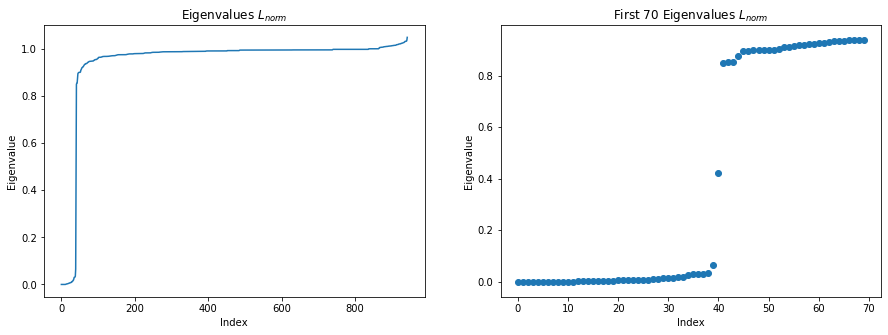

In [665]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

In order to observe the properties of the eigenvalues calculated, we zoom in the eigenvalues and we observe that there is a significant gap of eighvalues as shown in the plot, which correspond to the fact that there are about 40 clear clusters in the graph. As we know that if the data has exactly k clear clusters, there will be a gap in the Laplacian spectrum after the k-th eigenvalue. Here the clusters are generally defined by the occupation of the users. 

### Metric 2: meaure similarities between users by how many common movies they have rated

The more common movies two users have rated, the more similar they are.

In [452]:
# Calulate the number of common movies they have rated between two users
def common_movie(i,j,data):
    left = data[data['user_id']==i+1]['movie'].values.tolist()[0]
    right = data[data['user_id']==j+1]['movie'].values.tolist()[0]
    common = left.intersection(right)
    return len(common)

In [19]:
adjacency_user2 = np.zeros((n_users, n_users), dtype=float)
for i in range(n_users):
    print(i)
    for j in range(n_users):
        if j<i:
            adjacency_user2[i,j] = adjacency_user2[j,i]
        else:
            adjacency_user2[i,j] = common_movie(i,j,user_features2)
            
np.save('data/adjacency_user2.npy', adjacency_user2)

Histogram of the Median of common movies

Text(0.5, 1.0, 'histogram of number of common movies')

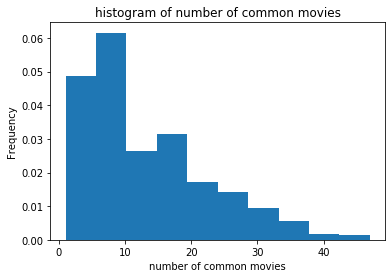

In [671]:
adjacency_user2 = np.load('data/adjacency_user2.npy')
median = []
for i in range(n_users):
    median.append(np.median(adjacency_user2[i,:]))

plt.hist(median, density=True)
plt.xlabel('number of common movies')
plt.ylabel('Frequency')
plt.title('histogram of number of common movies')

The adjacency matrix of **Metric 2**

Text(0.5, 1.05, 'Adjacency matrix')

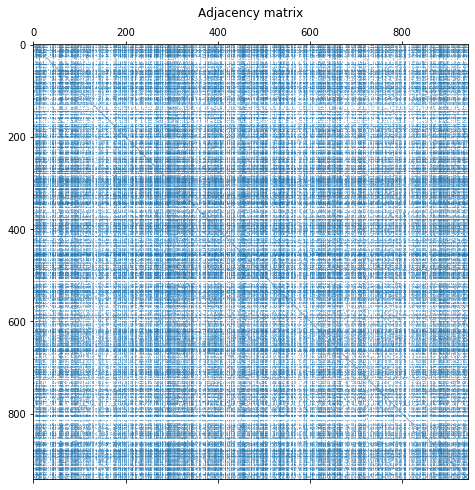

In [672]:
mask2 = adjacency_user2<20
adjacency = adjacency_user2.copy()
adjacency[mask2]=0

# Normalize 
adjacency_normalized = np.divide(adjacency,adjacency.max());
adjacency_normalized = adjacency
plt.figure(figsize=(8,8))
plt.spy(adjacency_normalized,markersize=0.1)
plt.title('Adjacency matrix')

#### User Graph 2 with colors representing Occupation

The number of connected components is 1


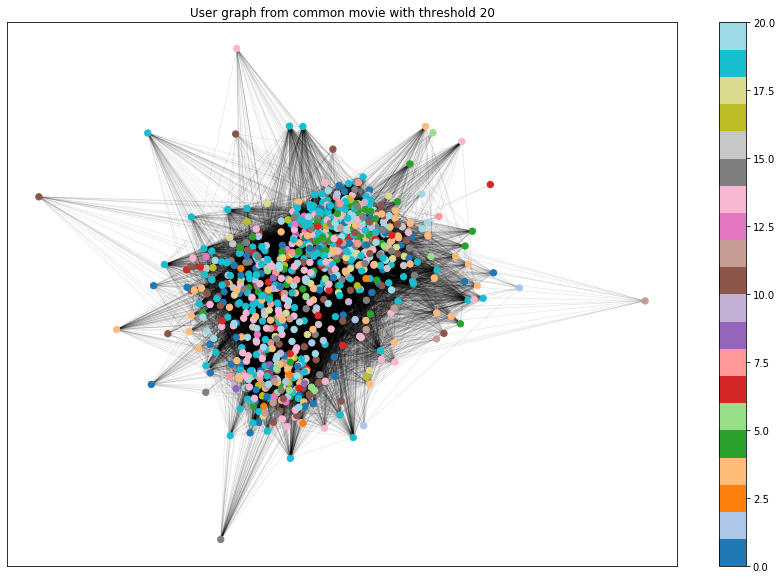

In [472]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features1['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### User Graph 2 with colors representing Average Rating

The number of connected components is 1


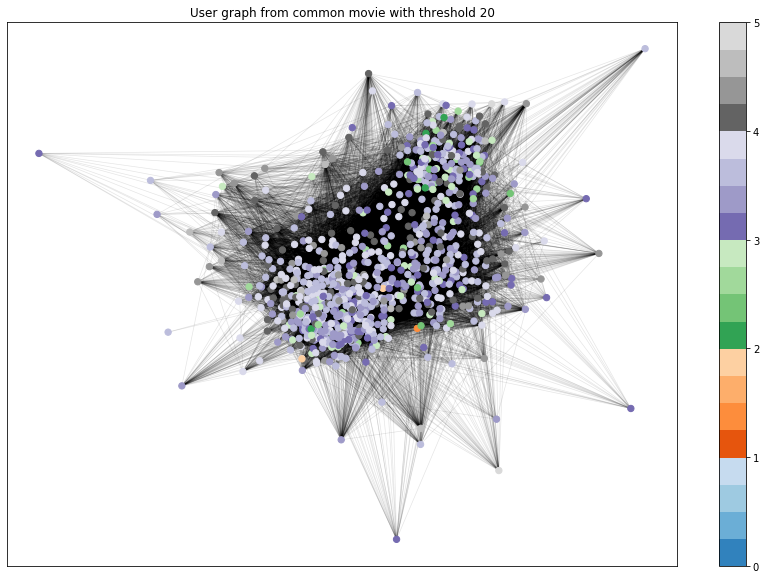

In [473]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=0, vmax=5)
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### User Graph 2 with colors representing Age of user

The number of connected components is 1


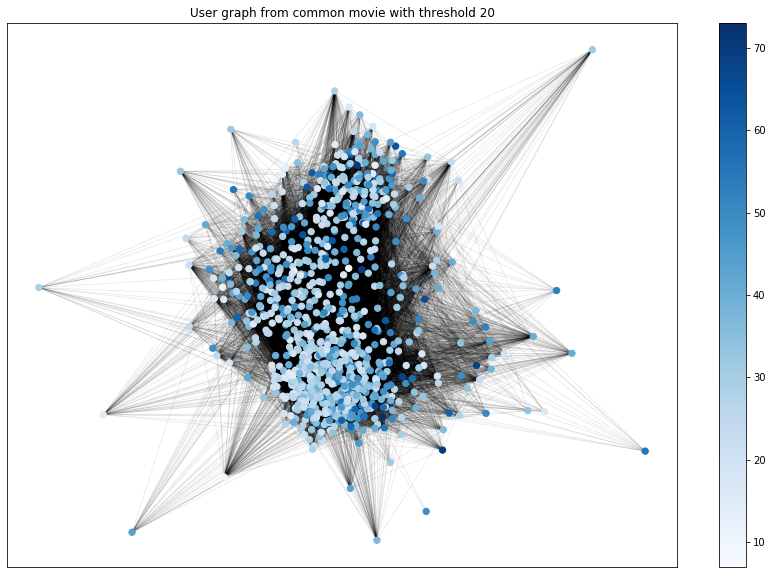

In [474]:
graph_user2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_user2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['age'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='Blues',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### Giant component of the User Graph 2 connected by at least 20 common movies

The number of nodes is is 943


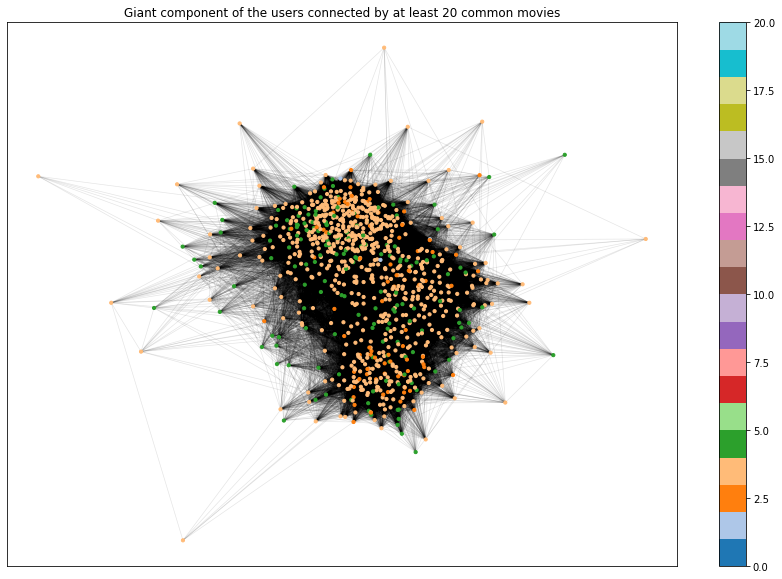

In [475]:
G = graph_user2
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.
print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = user_features2['avg_rating'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=10,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.7)
plt.title('Giant component of the users connected by at least 20 common movies')
plt.colorbar(im);

In [673]:
laplacian_norm = compute_laplacian(adjacency_normalized, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

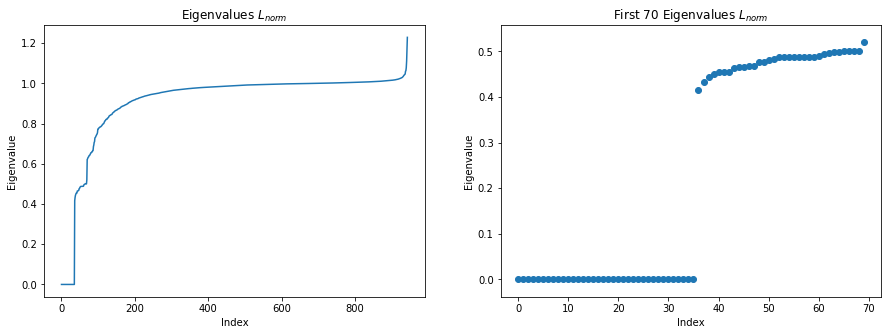

In [674]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

In order to observe the properties of the eigenvalues calculated, we zoom in the eigenvalues and we observe that there is a significant gap of eighvalues as shown in the plot, which correspond to the fact that there are about 35 clear clusters in the graph. As we know that if the data has exactly k clear clusters, there will be a gap in the Laplacian spectrum after the k-th eigenvalue. However, the pattern here in this user graph is not clear as most of them are not really clusters by outliers. There is only one giant component that dominates the graph.

#### User Graph withoutwhitening

The number of connected components is 1


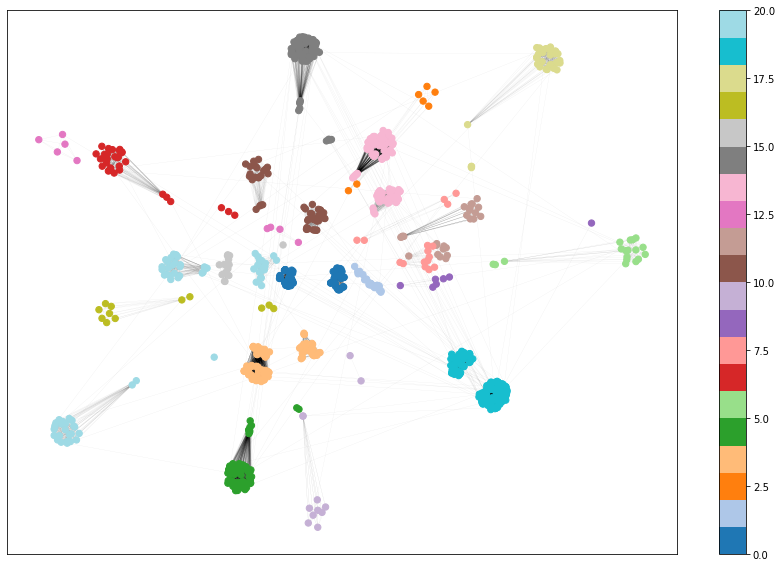

In [184]:
adjacency_user4 = np.load('data/user_no_whitening.npy')

graph_user4 = nx.from_numpy_matrix(adjacency_user4)
G = graph_user4
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.2)
#plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

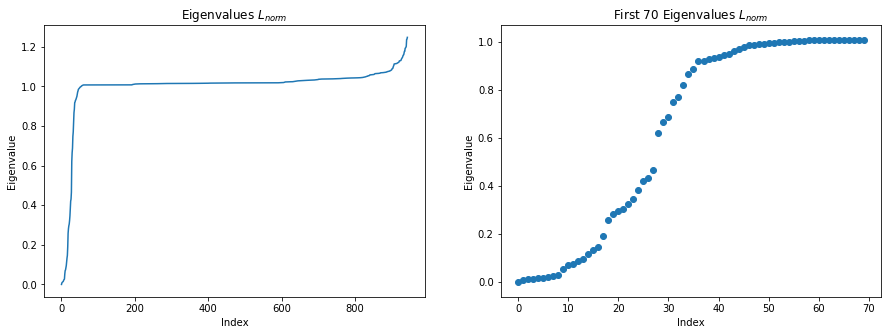

In [185]:
laplacian_norm = compute_laplacian(adjacency_user4, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

#### User Graph after whitening

The number of connected components is 21


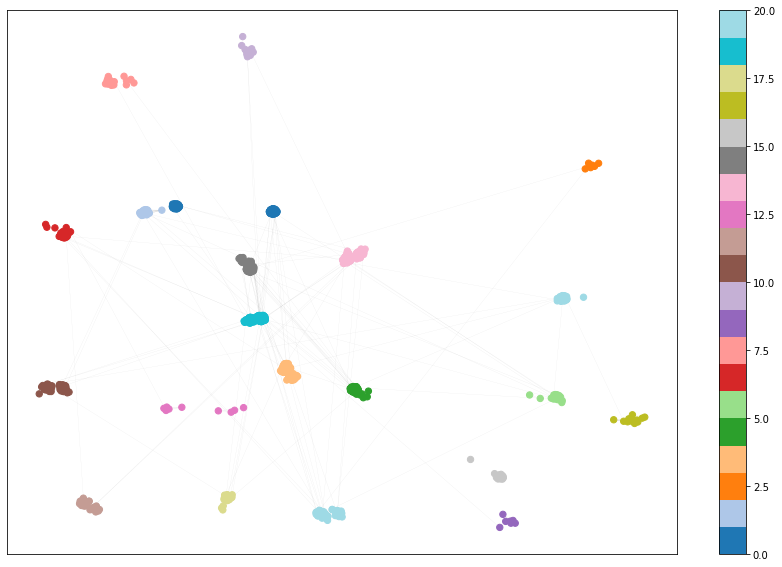

In [183]:
adjacency_user3 = np.load('data/user_whitening.npy')

graph_user3 = nx.from_numpy_matrix(adjacency_user3)
G = graph_user3
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = user_features2['occupation_id'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.2)
#plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

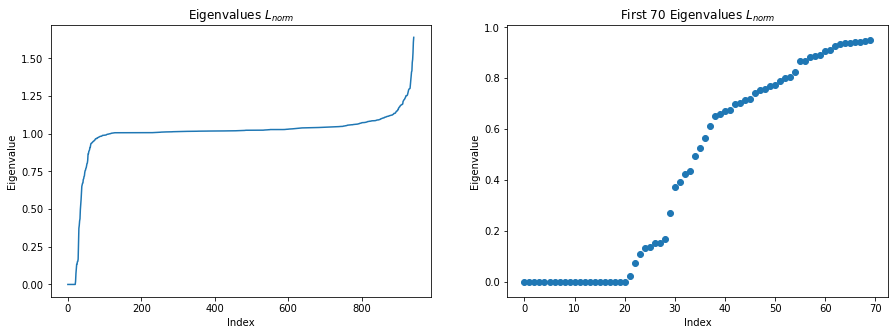

In [186]:
laplacian_norm = compute_laplacian(adjacency_user3, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')

plt.subplot(122)
first_k = 70
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 70 Eigenvalues $L_{norm}$')

plt.show()

#### Giant Component in user graph after Whitening 

The number of nodes is is 196


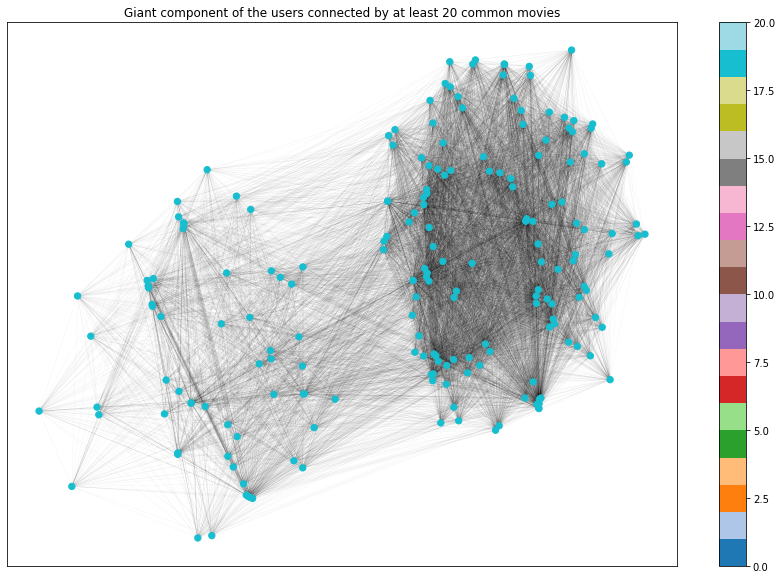

In [151]:
G = graph_user3
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.
print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = user_features2['occupation_id'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=40,node_color=labels, cmap='tab20',vmin=0, vmax=20)
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.2)
plt.title('Giant component of the users connected by at least 20 common movies')
plt.colorbar(im);

## 3.2 movie graph

### Metric 1: similarity between moives measured by genres

In [706]:
movie_features1 = movies_data[['item_id']+genre_cls]
movie_features1.loc[:, 'year_label'] = movies_data['year_label']
movie_features1.reset_index(drop = True, inplace = True)
movie_features1

item_id  unknown  Action  Adventure  Animation  Childrens  Comedy  \
0           1        0       0          0          1          1       1   
1           2        0       1          1          0          0       0   
2           3        0       0          0          0          0       0   
3           4        0       1          0          0          0       1   
4           5        0       0          0          0          0       0   
...       ...      ...     ...        ...        ...        ...     ...   
1677     1678        0       0          0          0          0       0   
1678     1679        0       0          0          0          0       0   
1679     1680        0       0          0          0          0       0   
1680     1681        0       0          0          0          0       1   
1681     1682        0       0          0          0          0       0   

      Crime  Documentary  Drama  ...  Film-Noir  Horror  Musical  Mystery  \
0         0            0      0  ...          0       0        0        0   
1         0            0      0  ...          0       0        0        0   
2         0            0      0  ...          0       0        0        0   
3         0            0      1  ...          0       0        0        0   
4         1            0      1  ...          0       0        0        0   
...     ...          ...    ...  ...        ...     ...      ...      ...   
1677      0            0      1  ...          0       0        0        0   
1678      0            0      0  ...          0       0        0        0   
1679      0            0      1  ...          0       0        0        0   
1680      0            0      0  ...          0       0        0        0   
1681      0            0      1  ...          0       0        0        0   

      Romance  Sci-Fi  Thriller  War  Western  year_label  
0           0       0         0    0        0      1995.0  
1           0       0         1    0        0      1995.0  
2           0       0         1    0        0      1995.0  
3           0       0         0    0        0      1995.0  
4           0       0         1    0        0      1995.0  
...       ...     ...       ...  ...      ...         ...  
1677        0       0         0    0        0      1998.0  
1678        1       0         1    0        0      1998.0  
1679        1       0         0    0        0      1998.0  
1680        0       0         0    0        0      1994.0  
1681        0       0         0    0        0      1996.0  

[1682 rows x 21 columns]

In [707]:
# Initialize the adjacency matrix
n_movies = len(movie_features1)
adjacency_movie = np.zeros((n_movies, n_movies), dtype=float)

In [743]:
for i in range(n_movies):
    adjacency_movie[i,:] = np.logical_and(movie_features1.loc[i,:][genre_cls], movie_features1[genre_cls])\
    .sum(axis=1)

Text(0.5, 1.05, 'Adjacency matrix')

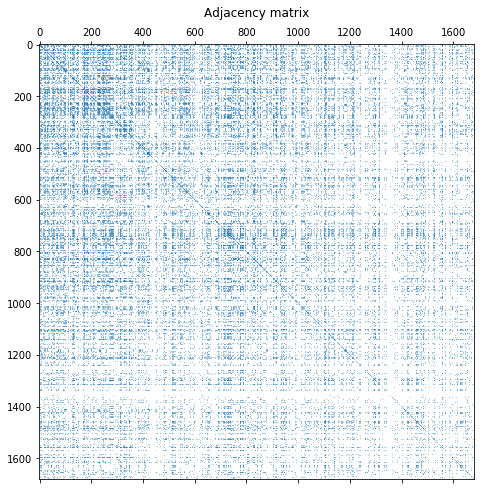

In [745]:
# Normalize 
mask_movie = adjacency_movie<2
adjacency = adjacency_movie.copy()
adjacency[mask_movie] = 0 
adjacency_movie_nor =np.divide(adjacency,adjacency.max())
plt.figure(figsize=(8,8))
plt.spy(adjacency_movie_nor,markersize=0.1)
plt.title('Adjacency matrix')

#### Movie graph 1 with colors representing release year

The number of connected components is 838


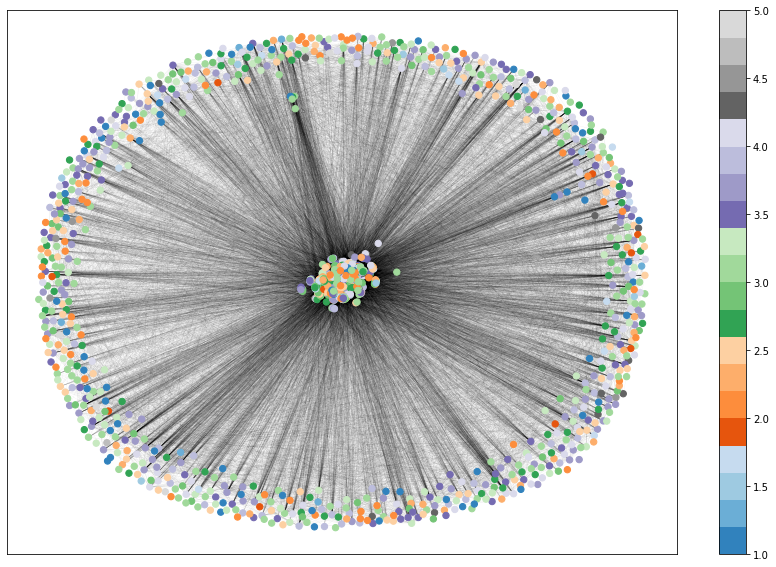

In [165]:
graph_movie1 = nx.from_numpy_matrix(adjacency_movie_nor)
G = graph_movie1
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.2)

plt.colorbar(im)

#### Giant Component of Movie Graph 1

The number of nodes is is 839


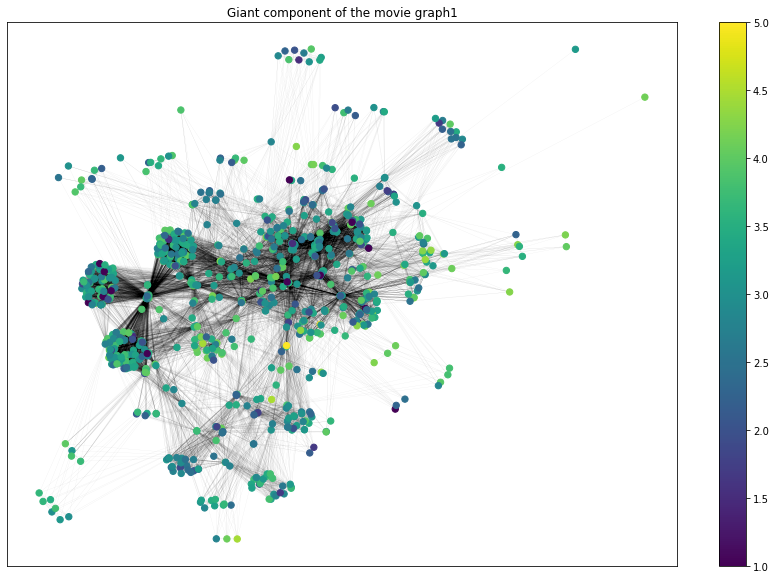

In [166]:
G = graph_movie1
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=40,node_color=labels,cmap='viridis',vmin=min(labels),vmax=max(labels))
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.2)
plt.title('Giant component of the movie graph1')
plt.colorbar(im);

### Metric 2: Similarity measured by the common users who have rated them

In [595]:
movie_features2 = movie_features1[['item_id','year_label']].copy()
movie_features2['avg_rating'] = data_merged[['user_id','item_id','rating']].groupby('item_id').mean()['rating'].values
movie_features2['user'] = data_merged[['user_id','item_id','rating']].groupby('item_id')['user_id'].apply(set).values

In [596]:
movie_features2

item_id  year_label  avg_rating  \
0           1      1995.0    3.878319   
1           2      1995.0    3.206107   
2           3      1995.0    3.033333   
3           4      1995.0    3.550239   
4           5      1995.0    3.302326   
...       ...         ...         ...   
1677     1678      1998.0    1.000000   
1678     1679      1998.0    3.000000   
1679     1680      1998.0    2.000000   
1680     1681      1994.0    3.000000   
1681     1682      1996.0    3.000000   

                                                   user  
0     {1, 2, 5, 6, 10, 13, 15, 16, 17, 18, 20, 21, 2...  
1     {1, 5, 521, 13, 532, 22, 536, 30, 543, 551, 42...  
2     {1, 523, 534, 537, 548, 551, 43, 49, 561, 569,...  
3     {1, 514, 7, 10, 12, 13, 524, 527, 16, 18, 19, ...  
4     {1, 13, 21, 28, 546, 551, 43, 44, 562, 577, 72...  
...                                                 ...  
1677                                              {863}  
1678                                              {863}  
1679                                              {863}  
1680                                              {896}  
1681                                              {916}  

[1682 rows x 4 columns]

In [597]:
def common_user(i,j,data):
    left = data[data['item_id']==i+1]['user'].values.tolist()[0]
    right = data[data['item_id']==j+1]['user'].values.tolist()[0]
    common = left.intersection(right)
    return len(common)

In [18]:
adjacency_movie2 = np.zeros((n_movies, n_movies), dtype=float)
for i in range(n_movies):
    print(i)
    for j in range(n_movies):
        if j<i:
            adjacency_movie2[i,j] = adjacency_movie2[j,i]
        else:
            adjacency_movie2[i,j] = common_user(i,j,movie_features2)
np.save('adjacency_movie2.npy', adjacency_movie2)

Text(0.5, 1.0, 'histogram of number of common user')

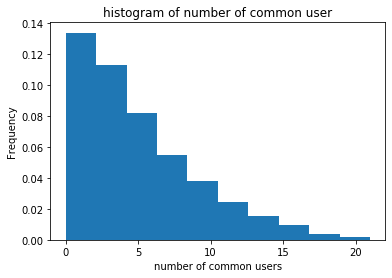

In [630]:
adjacency_movie2 = np.load('data/adjacency_movie2.npy')
median = []
for i in range(n_users):
    median.append(np.median(adjacency_movie2[i,:]))

plt.hist(median, density=True)
plt.xlabel('number of common users')
plt.ylabel('Frequency')
plt.title('histogram of number of common user')

Text(0.5, 1.05, 'Adjacency matrix')

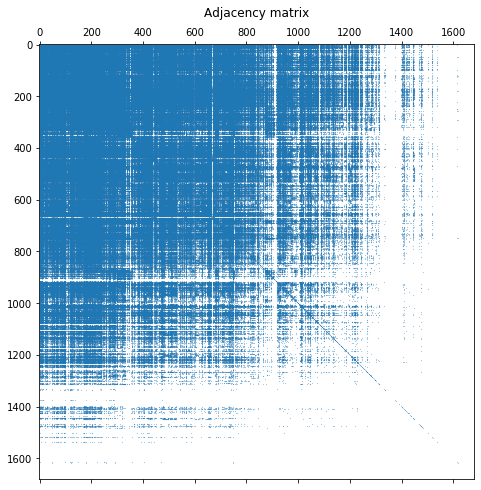

In [631]:
mask2 = adjacency_movie2<8
adjacency = adjacency_movie2.copy()
adjacency[mask2]=0
# Normalize 
adjacency_normalized = np.divide(adjacency,adjacency.max());
plt.figure(figsize=(8,8))
plt.spy(adjacency_normalized,markersize=0.1)
plt.title('Adjacency matrix')

#### Moive Graph 2

The number of connected components is 475


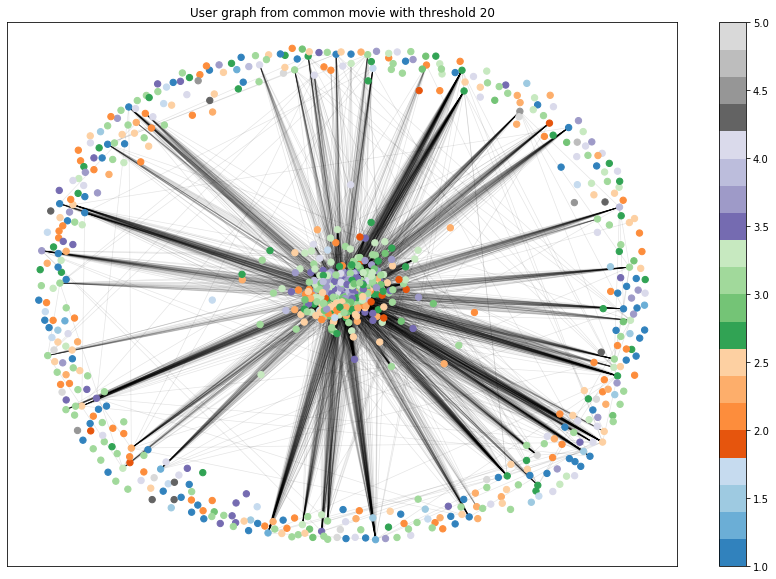

In [632]:
graph_movie2 = nx.from_numpy_matrix(adjacency_normalized)
G = graph_movie2
print('The number of connected components is {}'.format(nx.number_connected_components(G)))

coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.7)
plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### Giant Component of Movie Graph 2

The number of nodes is is 1208


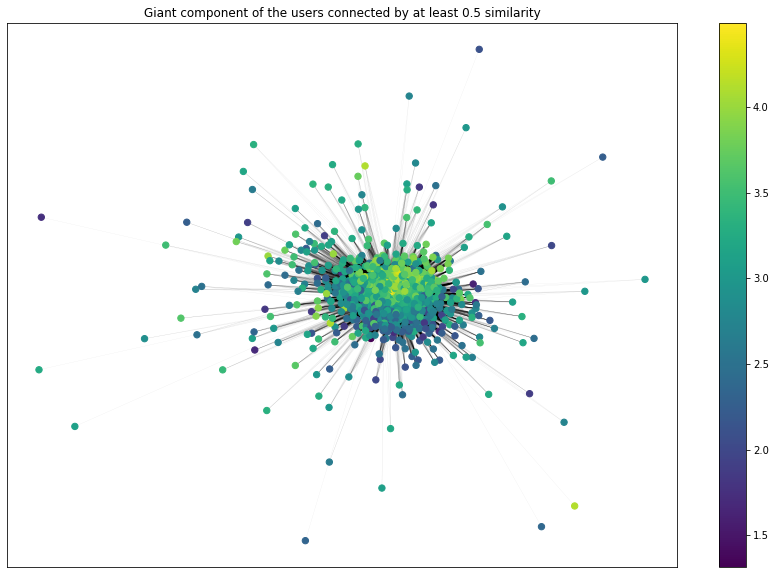

In [126]:
G = graph_movie2
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.

print('The number of nodes is is {}'.format(Gc.number_of_nodes()))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=40,node_color=labels,cmap='viridis',vmin=min(labels),vmax=max(labels))
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.2)
plt.title('Giant component of the users connected by at least 0.5 similarity')
plt.colorbar(im);

#### Anslysis from spectral graph

In [608]:
laplacian_norm = compute_laplacian(adjacency_movie2, normalize=True)
lamb_norm, U_norm = spectral_decomposition(laplacian_norm)

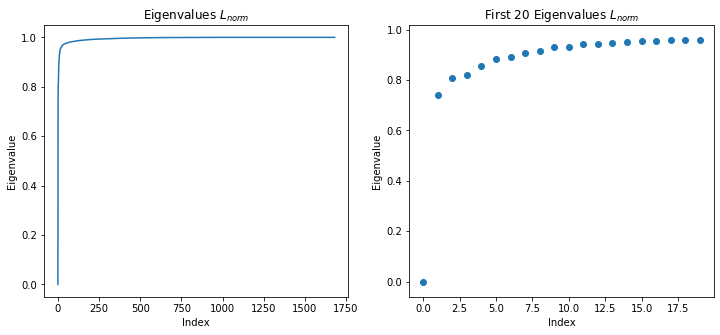

In [628]:
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(lamb_norm)
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('Eigenvalues $L_{norm}$')
plt.subplot(122)
first_k = 20
plt.scatter(range(first_k), lamb_norm[:first_k])
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.title('First 20 Eigenvalues $L_{norm}$')
plt.show()

In order to observe the properties of the eigenvalues calculated, we plot all the eigenvalues and the first 20 eigenvalues. In the second plot, we observe that the most significant gap is between the first eigen value and the second one, which correspond to the fact that there is one clear cluster (the giant component) in the graph. As we know that if the data has exactly k clear clusters, there will be a gap in the Laplacian spectrum after the k -th eigenvalue.

#### Movie graph before whitening

The number of connected components is 1


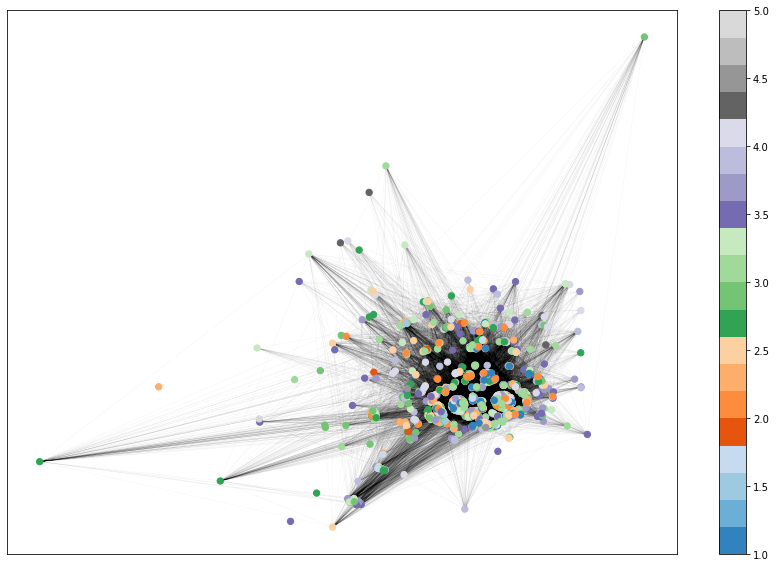

In [167]:
adjacency_movie4 = np.load('data/movie_no_whitening.npy')

graph_user4 = nx.from_numpy_matrix(adjacency_movie4)
G = graph_user4
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.2)
#plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

#### Movie graph after whitening

The number of connected components is 5


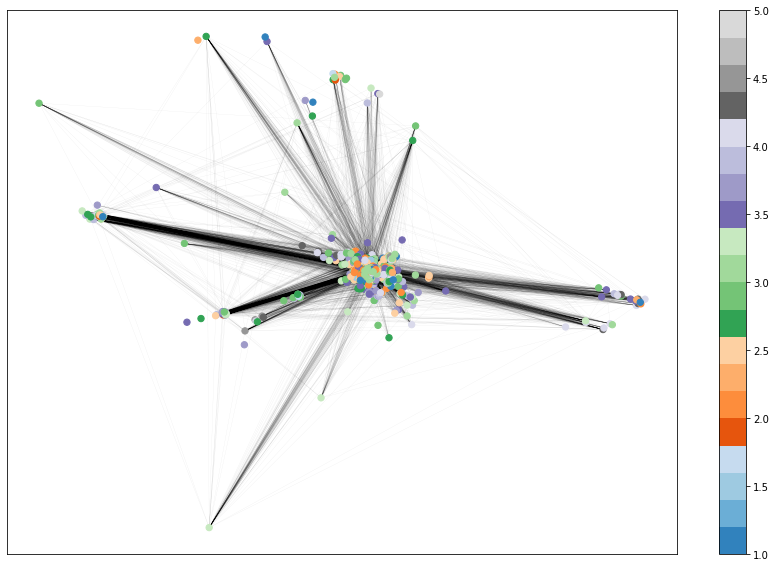

In [169]:
adjacency_movie4 = np.load('data/movie_whitening.npy')

graph_user4 = nx.from_numpy_matrix(adjacency_movie4)
G = graph_user4
print('The number of connected components is {}'.format(nx.number_connected_components(G)))
coords = nx.spring_layout(G,k=0.03)  # Force-directed layout.
fig=plt.figure(figsize=(15, 10))
labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(G))]
im=nx.draw_networkx_nodes(G, coords, node_size=40,node_color=labels, cmap='tab20c',vmin=min(labels), vmax=max(labels))
nx.draw_networkx_edges(graph_user, coords, alpha=0.1, width=0.2)
#plt.title('User graph from common movie with threshold 20')
plt.colorbar(im)

We observe that the whitening do denoise the graph and distinguishes the clusters better.

#### Giant component of movie graph after whitening

The number of nodes is is 1607


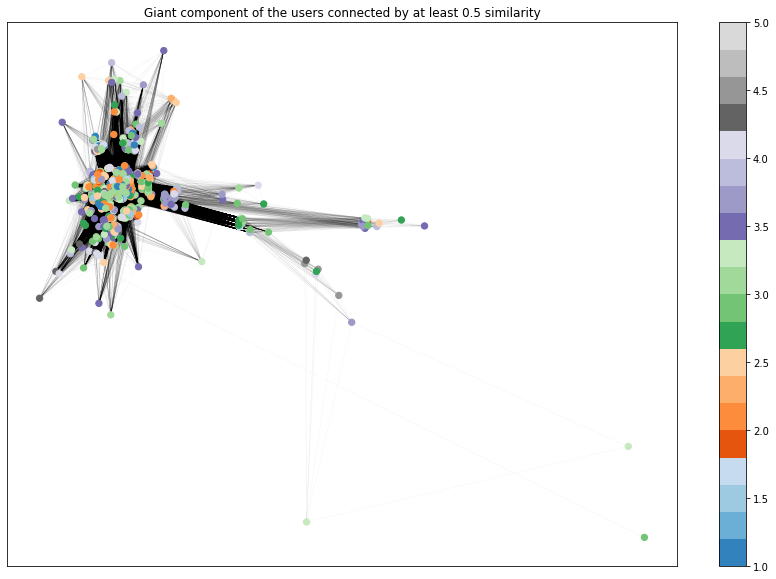

In [172]:
G = graph_user4
Gc = max([G.subgraph(c) for c in nx.connected_components(G)], key=len)
coords_Gc = nx.spring_layout(Gc,k=0.03)  # Force-directed layout.
print('The number of nodes is is {}'.format(Gc.number_of_nodes()))

labels = movie_features2['avg_rating'].iloc[np.sort(nx.nodes(Gc))]
fig=plt.figure(figsize=(15, 10))
im=nx.draw_networkx_nodes(Gc, coords_Gc, node_size=40,node_color=labels,cmap='tab20c',vmin=min(labels),vmax=max(labels))
nx.draw_networkx_edges(Gc, coords_Gc, alpha=0.1, width=0.2)
plt.title('Giant component of the users connected by at least 0.5 similarity')
plt.colorbar(im);